This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.
 
 #### Pipline
 * load data
 * heal data and remove outliers
 * work with shops/items/cats objects and features
 * create matrix as product of item/shop pairs within each month in the train set
 * get monthly sales for each item/shop pair in the train set and merge it to the matrix
 * clip item_cnt_month by (0,20)
 * append test to the matrix, fill 34 month nans with zeros
 * merge shops/items/cats to the matrix
 * add target lag features
 * add mean encoded features
 * add price trend features
 * add month
 * add days
 * add months since last sale/months since first sale features
 * cut first year and drop columns which can not be calculated for the test set
 * select best features
 * set validation strategy 34 test, 33 validation, less than 33 train
 * fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
cats = pd.read_csv('./data/item_categories.csv')
train = pd.read_csv('./data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./data/test.csv').set_index('ID')

In [3]:
train[train.item_cnt_day > 1001]

date  date_block_num  shop_id  item_id  item_price  \
2909818  28.10.2015              33       12    11373    0.908714   

         item_cnt_day  
2909818        2169.0

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

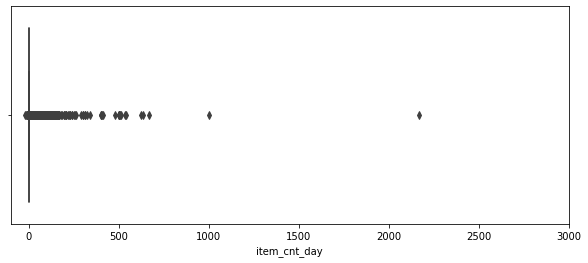

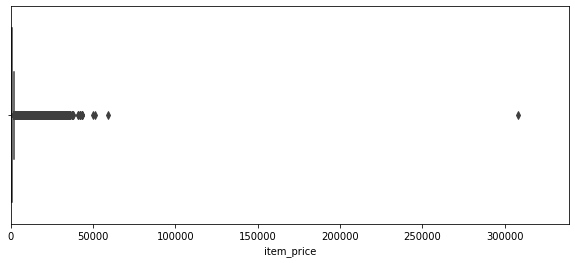

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [6]:
train

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
5        10.01.2013               0       25     2564      349.00   
6        02.01.2013               0       25     2565      549.00   
7        04.01.2013               0       25     2572      239.00   
8        11.01.2013               0       25     2572      299.00   
9        03.01.2013               0       25     2573      299.00   
10       03.01.2013               0       25     2574      399.00   
11       05.01.2013               0       25     2574      399.00   
12       07.01.2013               0       25     2574      399.00   
13       08.01.2013               0       25     2574      399.00   
14       10.01.2013               0       25     2574      399.00   
15       11.01.2013               0       25     2574      399.00   
16       13.01.2013               0       25     2574      399.00   
17       16.01.2013               0       25     2574      399.00   
18       26.01.2013               0       25     2574      399.00   
19       27.01.2013               0       25     2574      399.00   
20       09.01.2013               0       25     2593      279.00   
21       16.01.2013               0       25     2604      299.00   
22       27.01.2013               0       25     2604      299.00   
23       27.01.2013               0       25     2607      279.00   
24       29.01.2013               0       25     2607      279.00   
25       27.01.2013               0       25     2609     1699.00   
26       06.01.2013               0       25     2548     1708.95   
27       26.01.2013               0       25     2611      299.00   
28       02.01.2013               0       25     2546      299.00   
29       06.01.2013               0       25     2515     1649.00   
30       07.01.2013               0       25     2705     1799.00   
31       11.01.2013               0       25     2705     1799.00   
32       26.01.2013               0       25     2705     1799.00   
33       02.01.2013               0       25     2715      899.00   
34       12.01.2013               0       25     2715      898.50   
35       02.01.2013               0       25     2716      149.00   
36       23.01.2013               0       25     2716      149.00   
37       02.01.2013               0       25     2719     2699.00   
38       12.01.2013               0       25     2719     2699.00   
39       25.01.2013               0       25     2719     1699.00   
40       30.01.2013               0       25     2720     1699.00   
41       05.01.2013               0       25     2473      899.00   
42       02.01.2013               0       25     2480       58.00   
43       02.01.2013               0       25     2731      599.00   
44       19.01.2013               0       25     2731      599.00   
45       06.01.2013               0       25     2746      299.00   
46       07.01.2013               0       25     2746      299.00   
47       10.01.2013               0       25     2746      299.00   
48       12.01.2013               0       25     2746      299.00   
49       20.01.2013               0       25     2746      299.00   
50       24.01.2013               0       25     2746      299.00   
51       25.01.2013               0       25     2746      299.00   
52       04.01.2013               0       25     2748     1399.00   
53       23.01.2013               0       25     2748      799.00   
54       25.01.2013               0       25     2748      799.00   
55       06.01.2013               0       25     2522     1999.00   
56       19.01.2013               0       25     2614      299.00   
57       27.0

There is one item with price below zero. Fill it with median.

In [7]:
train.loc[train.item_price<0] 

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0

In [8]:
train.loc[train.item_price==1874] 

date  date_block_num  shop_id  item_id  item_price  \
844305   03.09.2013               8       52     2809      1874.0   
905278   03.09.2013               8       26     2809      1874.0   
909808   03.09.2013               8       30     2809      1874.0   
2774660  24.07.2015              30       28    17717      1874.0   

         item_cnt_day  
844305            4.0  
905278            4.0  
909808            4.0  
2774660           2.0

In [9]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [10]:
train[train.item_price == median]

date  date_block_num  shop_id  item_id  item_price  \
484683   15.05.2013               4       32     2973      1874.0   
844305   03.09.2013               8       52     2809      1874.0   
905278   03.09.2013               8       26     2809      1874.0   
909808   03.09.2013               8       30     2809      1874.0   
2774660  24.07.2015              30       28    17717      1874.0   

         item_cnt_day  
484683            1.0  
844305            4.0  
905278            4.0  
909808            4.0  
2774660           2.0

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [11]:
shops.loc[shops.shop_id == 11]

shop_name  shop_id
11  Жуковский ул. Чкалова 39м²       11

In [12]:
train.loc[train.shop_id == 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
37589   12.01.2013               0        0    11059        73.0           1.0
37590   22.01.2013               0        0    11059        73.0           1.0
37591   26.01.2013               0        0    11059        73.0           1.0
37592   12.01.2013               0        0    11347       170.0           1.0
37593   22.01.2013               0        0    11347       170.0           1.0
37594   22.01.2013               0        0    11061       111.0           1.0
37595   12.01.2013               0        0    11064       110.0           1.0
37596   12.01.2013               0        0    11065       110.0           1.0
37597   24.01.2013               0        0    11065       110.0           1.0
37598   26.01.2013               0        0    11065       110.0           1.0
37599   30.01.2013               0        0    11065       110.0           1.0
37600   05.01.2013               0        0    11077       137.0           1.0
37601   22.01.2013               0        0    11080        58.0           1.0
37602   06.01.2013               0        0    11081        76.0           1.0
37603   04.01.2013               0        0    11083       624.0           1.0
37604   19.01.2013               0        0    11093       110.0           1.0
37605   05.01.2013               0        0    11094        63.0           1.0
37606   04.01.2013               0        0    11095       178.0           1.0
37607   14.01.2013               0        0    11095       178.0           1.0
37608   23.01.2013               0        0    11095       178.0           1.0
37609   26.01.2013               0        0    11095       178.0           1.0
37610   05.01.2013               0        0    11359        83.0           1.0
37611   16.01.2013               0        0    11131        76.0           1.0
37612   23.01.2013               0        0    11131        76.0           1.0
37613   07.01.2013               0        0    11134        58.0           1.0
37614   08.01.2013               0        0    11059        73.0           1.0
37615   14.01.2013               0        0    11135       269.0           1.0
37616   31.01.2013               0        0    11045       226.0           1.0
37617   30.01.2013               0        0    11041       221.0           2.0
37618   03.01.2013               0        0    10928       110.0           1.0
37619   10.01.2013               0        0    10933        75.0           1.0
37620   10.01.2013               0        0    10939       100.0           1.0
37621   18.01.2013               0        0    10945       170.0           1.0
37622   16.01.2013               0        0    11334       166.0           1.0
37623   21.01.2013               0        0    11336       405.0           1.0
37624   22.01.2013               0        0    11336       405.0           1.0
37625   04.01.2013               0        0    10974       283.0           1.0
37626   08.01.2013               0        0    10980        71.0           1.0
37627   14.01.2013               0        0    11005       200.0           1.0
37628   15.01.2013               0        0    11005       200.0           1.0
37629   17.01.2013               0        0    11009        68.0           1.0
37630   06.01.2013               0        0    11012       110.0           1.0
37631   18.01.2013               0        0    11027       263.0           1.0
37632   21.01.2013               0        0    11030        77.0           1.0
37633   04.01.2013               0        0    11031      1536.0           1.0
37634   04.01.2013               0        0    11032       615.0           1.0
37635   11.01.2013               0        0    11032       615.0           1.0
37636   03.01.2013               0        0    11041       221.0           3.0
37637   04.01.2013               0        0    11041       221.0           9.0
37638   05.01.2013               0        0    11041       221.0

In [13]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Shops/Cats/Items preprocessing
 Observations:
 * Each shop_name starts with the city name.
 * Each category contains type and subtype in its name.

In [14]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [15]:
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [16]:
cats['split'] = cats['item_category_name'].str.split('-')

In [17]:
cats['split'].head()

0    [PC ,  Гарнитуры/Наушники]
1           [Аксессуары ,  PS2]
2           [Аксессуары ,  PS3]
3           [Аксессуары ,  PS4]
4           [Аксессуары ,  PSP]
Name: split, dtype: object

In [18]:
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type'].head()

0            PC
1    Аксессуары
2    Аксессуары
3    Аксессуары
4    Аксессуары
Name: type, dtype: object

In [19]:
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

In [20]:
cats['type_code'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  9, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [21]:
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype'].head()

0    Гарнитуры/Наушники
1                   PS2
2                   PS3
3                   PS4
4                   PSP
Name: subtype, dtype: object

In [22]:
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [23]:
items

item_id  item_category_id
0            0                40
1            1                76
2            2                40
3            3                40
4            4                40
5            5                40
6            6                40
7            7                40
8            8                40
9            9                40
10          10                40
11          11                40
12          12                55
13          13                40
14          14                40
15          15                40
16          16                40
17          17                40
18          18                40
19          19                40
20          20                40
21          21                40
22          22                40
23          23                40
24          24                40
25          25                40
26          26                40
27          27                19
28          28                30
29          29                23
30          30                40
31          31                37
32          32                40
33          33                37
34          34                40
35          35                40
36          36                37
37          37                40
38          38                41
39          39                41
40          40                57
41          41                57
42          42                57
43          43                40
44          44                57
45          45                57
46          46                57
47          47                57
48          48                57
49          49                57
50          50                57
51          51                57
52          52                57
53          53                57
54          54                57
55          55                43
56          56                57
57          57                57
58          58                78
59          59                57
60          60                43
61          61                43
62          62                37
63          63                40
64          64                40
65          65                37
66          66                37
67          67                40
68          68                30
69          69                54
70          70                49
71          71                37
72          72                40
73          73                40
74          74                37
75          75                40
76          76                37
77          77                40
78          78                40
79          79                40
80          80                37
81          81                40
82          82                37
83          83                40
84          84                40
85          85                37
86          86                40
87          87                37
88          88                40
89          89                40
90          90                40
91          91                37
92          92                37
93          93                43
94          94                40
95          95                40
96          96                40
97          97                40
98          98                40
99          99                37
100        100                40
101        101                78
102        102                76
103        103                76
104        104                76
105        105                30
106        106                30
107        107                44
108        108                44
109        109                57
110        110                44
111        111                57
112        112                44
113        113                57
114        114                44
115        115                57
116        116                57
117        117                44
118        118                44
119        119                44
120        120

# Monthly sales
 Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
 In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [24]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [25]:
temp = train[train.date_block_num==0]

In [26]:
len(train.item_id.unique()), len(temp.item_id.unique())

(21806, 8115)

In [27]:
ts = time.time()

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols,inplace=True)

time.time() - ts

8.419084310531616

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.
 
 <i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [28]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [29]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

4.304029941558838

In [30]:
matrix['item_cnt_month'].max()

20.0

In [31]:
matrix.item_cnt_month.describe()

count    10913804.0
mean            NaN
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max            20.0
Name: item_cnt_month, dtype: float64

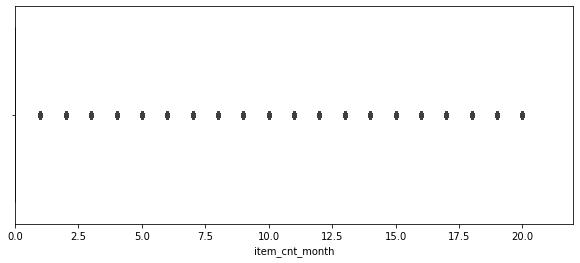

In [32]:
plt.figure(figsize=(10,4))
plt.xlim(matrix.item_cnt_month.min(), matrix.item_cnt_month.max()*1.1)
sns.boxplot(x=matrix.item_cnt_month)

# Test set
 To use time tricks append test pairs to the matrix.

In [33]:
test.head()

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268

In [34]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [35]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.04787421226501465

In [36]:
cols

['date_block_num', 'shop_id', 'item_id']

# Shops/Items/Cats features

In [37]:
shops.head()

shop_id  city_code
0        0         29
1        1         29
2        2          0
3        3          1
4        4          2

In [38]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.154309272766113

# Traget lags

In [39]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [40]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

26.579728603363037

# Mean encoded features

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.406992435455322

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
# 請將下列2,3,6,12數字刪除，看XGBoost訓練完的分數變高或低？
# matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.610273599624634

In [43]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

31.198720455169678

In [44]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.972906589508057

In [45]:
matrix.item_category_id.unique()

array([40, 19, 30, 23, 37, 57, 43, 45, 49, 73, 77, 55, 67, 75, 59, 58, 60,
       56, 21, 28, 62, 22, 29,  4, 63, 18, 15, 68,  2,  5,  1,  3, 35, 25,
       14, 13, 11, 69, 64,  6, 33, 66, 38, 41, 65, 46, 70,  9, 82, 81, 71,
        0, 79, 61, 72, 83, 48, 10, 44, 76, 54, 31, 78, 52, 32, 39, 53, 20,
       12, 17, 34,  8, 16, 51, 24, 74,  7, 27, 26, 47, 50, 42, 80, 36],
      dtype=int64)

In [46]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
# 將1後面加上3,6,9，看XGBoost的分數變高或變低？
matrix = lag_feature(matrix, [1,3,6,9], 'date_shop_cat_avg_item_cnt')
# matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

27.481444597244263

In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.281517028808594

In [48]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.352570295333862

In [49]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_6',
       'date_shop_cat_avg_item_cnt_lag_9', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1'],
      dtype='object')

In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.065810441970825

In [51]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.959063291549683

In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.57025671005249

In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.461334705352783

# Trend features

Price trend for the last six months.

In [54]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [55]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [56]:
lags

[1, 2, 3, 4, 5, 6]

In [57]:
matrix[9200000:9200010]

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
9200000              26       42    14845             2.0         19   
9200001              26       42    14846             3.0         19   
9200002              26       42    14847             5.0         19   
9200003              26       42    14848             0.0         19   
9200004              26       42    14855             0.0         19   
9200005              26       42    14860             0.0         19   
9200006              26       42    14865             1.0         19   
9200007              26       42    14866             0.0         19   
9200008              26       42    14872             0.0         19   
9200009              26       42    14881             0.0         19   

         item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
9200000                65         14            43                   5.0   
9200001                65         14            43                   2.0   
9200002                65         14            43                   5.0   
9200003                65         14            43                   2.0   
9200004                40         11             4                   0.0   
9200005                40         11             4                   NaN   
9200006                40         11             4                   3.0   
9200007                37         11             1                   2.0   
9200008                55         13             2                   0.0   
9200009                41         11            35                   1.0   

         item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
9200000                   0.0                   2.0                   0.0   
9200001                   1.0                   5.0                   0.0   
9200002                   2.0                   6.0                   0.0   
9200003                   6.0                   7.0                   NaN   
9200004                   0.0                   0.0                   0.0   
9200005                   NaN                   0.0                   0.0   
9200006                   NaN                   NaN                   NaN   
9200007                   NaN                   NaN                   NaN   
9200008                   NaN                   NaN                   1.0   
9200009                   NaN                   0.0                   0.0   

         item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
9200000                    4.0                 0.278076   
9200001                    NaN                 0.278076   
9200002                    2.0                 0.278076   
9200003                    NaN                 0.278076   
9200004                    NaN                 0.278076   
9200005                    0.0                      NaN   
9200006                    NaN                 0.278076   
9200007                    NaN                 0.278076   
9200008                    0.0                 0.278076   
9200009                    0.0                 0.278076   

         date_item_avg_item_cnt_lag_1  date_shop_avg_item_cnt_lag_1  \
9200000                      0.978516                      0.589355   
9200001                      0.787109                      0.589355   
9200002                      0.468018                      0.589355   
9200003                      1.021484                      0.589355   
9200004                      0.063843                      0.589355   
9200005                           NaN                           NaN   
9200006                      0.638184                      0.589355   
9200007                      0.361816                      0.589355   
9200008                      0.042542                      0.589355   
9200009                      0.191528                      0.589355   

         date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
9200000                     

In [58]:
matrix[9200000:9200010].apply(select_trend, axis=1)

9200000   -0.074829
9200001    0.024612
9200002   -0.048676
9200003    0.062805
9200004    0.105774
9200005         NaN
9200006    0.245117
9200007    0.424316
9200008   -0.674316
9200009   -0.638184
dtype: float64

In [59]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)

In [60]:
matrix['delta_price_lag'].fillna(0, inplace=True)

In [61]:
matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']][900000:900010]

delta_price_lag_1  delta_price_lag_2  delta_price_lag_3
900000           0.017807           0.012062                NaN
900001          -0.037170           0.142822                NaN
900002           0.015717          -0.008888                NaN
900003           0.386719                NaN                NaN
900004           0.535156           0.539551                NaN
900005           0.714844           1.359375                NaN
900006           0.167969          -0.049286                NaN
900007           0.048981           0.036346                NaN
900008           0.017929           0.229004                NaN
900009           0.070374          -0.034027                NaN

In [62]:
temp = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']][900000:900010].astype(np.float32)
temp.bfill(axis=1).iloc[:, 0]

900000    0.017807
900001   -0.037170
900002    0.015717
900003    0.386719
900004    0.535156
900005    0.714844
900006    0.167969
900007    0.048981
900008    0.017929
900009    0.070374
Name: delta_price_lag_1, dtype: float32

In [63]:
# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
temp = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].astype(np.float32)
matrix['price_trend'] = temp.bfill(axis=1).iloc[:, 0].astype(np.float16)
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]
fetures_to_drop

['item_avg_item_price',
 'date_item_avg_item_price',
 'date_item_avg_item_price_lag_1',
 'delta_price_lag_1',
 'date_item_avg_item_price_lag_2',
 'delta_price_lag_2',
 'date_item_avg_item_price_lag_3',
 'delta_price_lag_3',
 'date_item_avg_item_price_lag_4',
 'delta_price_lag_4',
 'date_item_avg_item_price_lag_5',
 'delta_price_lag_5',
 'date_item_avg_item_price_lag_6',
 'delta_price_lag_6']

In [64]:
matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [65]:
matrix[900000:900010]

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
900000               2       25     4474             5.0         13   
900001               2       25     4475             2.0         13   
900002               2       25     4476             0.0         13   
900003               2       25     4477             5.0         13   
900004               2       25     4481             3.0         13   
900005               2       25     4482             4.0         13   
900006               2       25     4484             1.0         13   
900007               2       25     4485             2.0         13   
900008               2       25     4486             0.0         13   
900009               2       25     4487             0.0         13   

        item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
900000                19          5            10                   1.0   
900001                21          5            13                   4.0   
900002                19          5            10                   3.0   
900003                19          5            10                   0.0   
900004                22          5            14                   1.0   
900005                19          5            10                   2.0   
900006                21          5            13                   0.0   
900007                21          5            13                   1.0   
900008                19          5            10                   0.0   
900009                23          5            16                   1.0   

        item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
900000                   2.0                   NaN                   NaN   
900001                   3.0                   NaN                   NaN   
900002                   2.0                   NaN                   NaN   
900003                   NaN                   NaN                   NaN   
900004                   3.0                   NaN                   NaN   
900005                   4.0                   NaN                   NaN   
900006                   2.0                   NaN                   NaN   
900007                   0.0                   NaN                   NaN   
900008                   0.0                   NaN                   NaN   
900009                   1.0                   NaN                   NaN   

        item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
900000                    NaN                 0.324463   
900001                    NaN                 0.324463   
900002                    NaN                 0.324463   
900003                    NaN                 0.324463   
900004                    NaN                 0.324463   
900005                    NaN                 0.324463   
900006                    NaN                 0.324463   
900007                    NaN                 0.324463   
900008                    NaN                 0.324463   
900009                    NaN                 0.324463   

        date_item_avg_item_cnt_lag_1  date_shop_avg_item_cnt_lag_1  \
900000                      1.456055                      0.898438   
900001                      2.064453                      0.898438   
900002                      0.543457                      0.898438   
900003                      0.217407                      0.898438   
900004                      1.173828                      0.898438   
900005                      0.978027                      0.898438   
900006                      0.217407                      0.898438   
900007                      0.521973                      0.898438   
900008                      0.065247                      0.898438   
900009                      0.086975                      0.898438   

        date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
900000                      0.947754                           NaN   
900001       

Last month shop revenue trend

In [66]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

13.798401832580566

# Special features

In [67]:
matrix['month'] = matrix['date_block_num'] % 12

In [68]:
matrix['month'].head()

0    0
1    0
2    0
3    0
4    0
Name: month, dtype: int8

Number of days in a month. There are no leap years.

In [69]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [70]:
matrix['month'].replace(0,12,inplace=True)

Months since the last sale for each shop/item pair and for item only. I use programing approach.
 
 <i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [71]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

832.2509043216705

In [72]:
cache['969.0 45.0']

34.0

In [73]:
matrix[(matrix.shop_id == 45) & (matrix.item_id == 19889)]

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
275267                 0       45    19889             2.0         20   
650417                 1       45    19889             0.0         20   
1030806                2       45    19889             0.0         20   
1407178                3       45    19889             0.0         20   
1771977                4       45    19889             0.0         20   
2160287                5       45    19889             0.0         20   
2547806                6       45    19889             0.0         20   
2913712                7       45    19889             0.0         20   
3270017                8       45    19889             0.0         20   
3637692                9       45    19889             0.0         20   
4001196               10       45    19889             1.0         20   
4377822               11       45    19889             0.0         20   
4737240               12       45    19889             0.0         20   
5070873               13       45    19889             0.0         20   
5743524               15       45    19889             0.0         20   
6072352               16       45    19889             0.0         20   
6399761               17       45    19889             0.0         20   
6731322               18       45    19889             0.0         20   
11127984              34       45    19889             0.0         20   

          item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
275267                  40         11             4                   NaN   
650417                  40         11             4                   2.0   
1030806                 40         11             4                   0.0   
1407178                 40         11             4                   0.0   
1771977                 40         11             4                   0.0   
2160287                 40         11             4                   0.0   
2547806                 40         11             4                   0.0   
2913712                 40         11             4                   0.0   
3270017                 40         11             4                   0.0   
3637692                 40         11             4                   0.0   
4001196                 40         11             4                   0.0   
4377822                 40         11             4                   1.0   
4737240                 40         11             4                   0.0   
5070873                 40         11             4                   0.0   
5743524                 40         11             4                   NaN   
6072352                 40         11             4                   0.0   
6399761                 40         11             4                   0.0   
6731322                 40         11             4                   0.0   
11127984                40         11             4                   NaN   

          item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
275267                     NaN                   NaN                   NaN   
650417                     NaN                   NaN                   NaN   
1030806                    2.0                   NaN                   NaN   
1407178                    0.0                   2.0                   NaN   
1771977                    0.0                   0.0                   NaN   
2160287                    0.0                   0.0                   NaN   
2547806                    0.0                   0.0                   2.0   
2913712                    0.0                   0.0                   0.0   
3270017                    0.0                   0.0                   0.0   
3637692                    0.0                   0.0                   0.0   
4001196                    0.0                   0.0                   0.0   
4377822                    0.0                   0.0                   0

In [74]:
matrix[matrix.item_shop_last_sale > 5]

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
2264244                6        2     4727             0.0          0   
2273294                6        3     6489             0.0          1   
2281054                6        4     4727             0.0          2   
2304267                6        6    20466             0.0          4   
2305647                6        7     2803             0.0          4   
2306822                6        7     6227             0.0          4   
2314593                6       11     4536             0.0          6   
2341616                6       14     9271             0.0          8   
2345112                6       14    17682             0.0          8   
2345113                6       14    17684             0.0          8   
2348213                6       15     4536             0.0          9   
2356032                6       16     2702             0.0         10   
2380225                6       18    21769             0.0         11   
2390872                6       21     6227             0.0         13   
2395105                6       21    16660             0.0         13   
2405440                6       22    21769             0.0         13   
2414677                6       25     2202             1.0         13   
2414807                6       25     2548             0.0         13   
2415810                6       25     5501             1.0         13   
2416442                6       25     7285             0.0         13   
2420372                6       25    16760             0.0         13   
2424492                6       26     6227             0.0         13   
2445587                6       28    16760             0.0         13   
2445972                6       28    17682             0.0         13   
2503913                6       38    15388             0.0         17   
2525444                6       43     6489             0.0         19   
2546395                6       45    16660             0.0         20   
2559064                6       47     6489             0.0         22   
2595104                6       53    12288             0.0         25   
2600877                6       54     5925             1.0         26   
2602779                6       54    10792             1.0         26   
2607160                6       54    21769             0.0         26   
2616196                6       56     1678             0.0         28   
2631193                6       57    18447             0.0         29   
2647255                6       59    16660             0.0         30   
2671278                7        4    16417             0.0          2   
2681781                7        6     1214             0.0          4   
2687534                7        6    16862             0.0          4   
2689929                7        7     1600             0.0          4   
2707255                7       12     5371             2.0          7   
2712636                7       12    19207             0.0          7   
2713311                7       12    21462             0.0          7   
2719658                7       13    16862             0.0          8   
2727466                7       14    16324             0.0          8   
2731841                7       15     6746             0.0          9   
2738115                7       16     1600             0.0         10   
2745185                7       16    20205             0.0         10   
2754177                7       18     1600             0.0         11   
2769278                7       19    20205             0.0         12   
2771996                7       21     6746             0.0         13   
2787565                7       24     5371             0.0         13   
2787748                7       24     5890             0.0         13   
2794332                7       25     1600             0.0         13   
2794831                7       25     3050             0.0         1

In [75]:
matrix.iloc[[idx]]

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
11128003              34       45      969             0.0         20   

          item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
11128003                37         11             1                   0.0   

          item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
11128003                   0.0                   0.0                   0.0   

          item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
11128003                    0.0                 0.258545   

          date_item_avg_item_cnt_lag_1  date_shop_avg_item_cnt_lag_1  \
11128003                      0.068176                      0.126709   

          date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
11128003                      0.128784                      0.139038   

          date_shop_avg_item_cnt_lag_6  date_shop_avg_item_cnt_lag_12  \
11128003                      0.137573                       0.181274   

          date_cat_avg_item_cnt_lag_1  date_shop_cat_avg_item_cnt_lag_1  \
11128003                     0.256836                          0.128174   

          date_shop_cat_avg_item_cnt_lag_3  date_shop_cat_avg_item_cnt_lag_6  \
11128003                          0.122009                          0.088379   

          date_shop_cat_avg_item_cnt_lag_9  date_shop_type_avg_item_cnt_lag_1  \
11128003                          0.104187                           0.097046   

          date_shop_subtype_avg_item_cnt_lag_1  date_city_avg_item_cnt_lag_1  \
11128003                              0.126343                      0.135376   

          date_item_city_avg_item_cnt_lag_1  date_type_avg_item_cnt_lag_1  \
11128003                                0.5                      0.224243   

          date_subtype_avg_item_cnt_lag_1  delta_price_lag  price_trend  \
11128003                         0.240967        -0.605957    -0.605957   

          delta_revenue_lag_1  month  days  item_shop_last_sale  
11128003            -0.290039     10    30                    1

In [76]:
matrix.at[987654, 'item_shop_last_sale']

-1

In [77]:
matrix.shape

(11128004, 37)

In [78]:
temp = matrix[(matrix.shop_id == 2) & (matrix.item_id == 33)]
temp

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
5                      0        2       33             1.0          0   
365181                 1        2       33             0.0          0   
740908                 2        2       33             0.0          0   
1122800                3        2       33             0.0          0   
1497471                4        2       33             0.0          0   
1872725                5        2       33             0.0          0   
2262714                6        2       33             0.0          0   
2649344                7        2       33             0.0          0   
3010738                8        2       33             0.0          0   
3365159                9        2       33             0.0          0   
3734952               10        2       33             2.0          0   
4098958               11        2       33             1.0          0   
4488714               12        2       33             1.0          0   
4836059               13        2       33             0.0          0   
5164226               14        2       33             0.0          0   
5507040               15        2       33             0.0          0   
5838966               16        2       33             0.0          0   
6166531               17        2       33             0.0          0   
6493902               18        2       33             0.0          0   
6824457               19        2       33             0.0          0   
7148970               20        2       33             1.0          0   
7452514               21        2       33             0.0          0   
7781883               22        2       33             0.0          0   
8097983               23        2       33             0.0          0   
8428231               24        2       33             0.0          0   
8735181               25        2       33             1.0          0   
9019671               26        2       33             0.0          0   
9299445               27        2       33             1.0          0   
9556815               28        2       33             1.0          0   
9789267               29        2       33             0.0          0   
10013555              30        2       33             1.0          0   
10242444              31        2       33             0.0          0   
10456980              32        2       33             1.0          0   
10675635              33        2       33             0.0          0   
10936296              34        2       33             0.0          0   

          item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
5                       37         11             1                   NaN   
365181                  37         11             1                   1.0   
740908                  37         11             1                   0.0   
1122800                 37         11             1                   0.0   
1497471                 37         11             1                   0.0   
1872725                 37         11             1                   0.0   
2262714                 37         11             1                   0.0   
2649344                 37         11             1                   0.0   
3010738                 37         11             1                   0.0   
3365159                 37         11             1                   0.0   
3734952                 37         11             1                   0.0   
4098958                 37         11             1                   2.0   
4488714                 37         11             1                   1.0   
4836059                 37         11             1                   1.0   
5164226                 37         11             1                   0.0   
5507040                 37         11             1                   0.0   
5838966                 37         11             1                   0.

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

# Final preparations
 Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [114]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [115]:
# 40 個欄位
data1 = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_2',
#     'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'price_trend',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
# 40 個欄位
data2 = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_3',
    'date_shop_cat_avg_item_cnt_lag_6',
    'date_shop_cat_avg_item_cnt_lag_9',    
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'price_trend',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [116]:
X_train = data1[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data1[data.date_block_num < 33]['item_cnt_month']
X_valid = data1[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data1[data.date_block_num == 33]['item_cnt_month']
X_test = data1[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [117]:
del data
gc.collect();

In [118]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=500,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=123)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

C:\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:45] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12568	validation_1-rmse:1.1181
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08488	validation_1-rmse:1.08048
[2]	validation_0-rmse:1.05167	validation_1-rmse:1.04922
[3]	validation_0-rmse:1.00969	validation_1-rmse:1.02335
[4]	validation_0-rmse:0.983658	validation_1-rmse:1.00474
[5]	validation_0-rmse:0.961789	validation_1-rmse:0.986422
[6]	validation_0-rmse:0.941805	validation_1-rmse:0.97269
[7]	validation_0-rmse:0.923617	

1690.0047235488892

In [119]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_0305.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

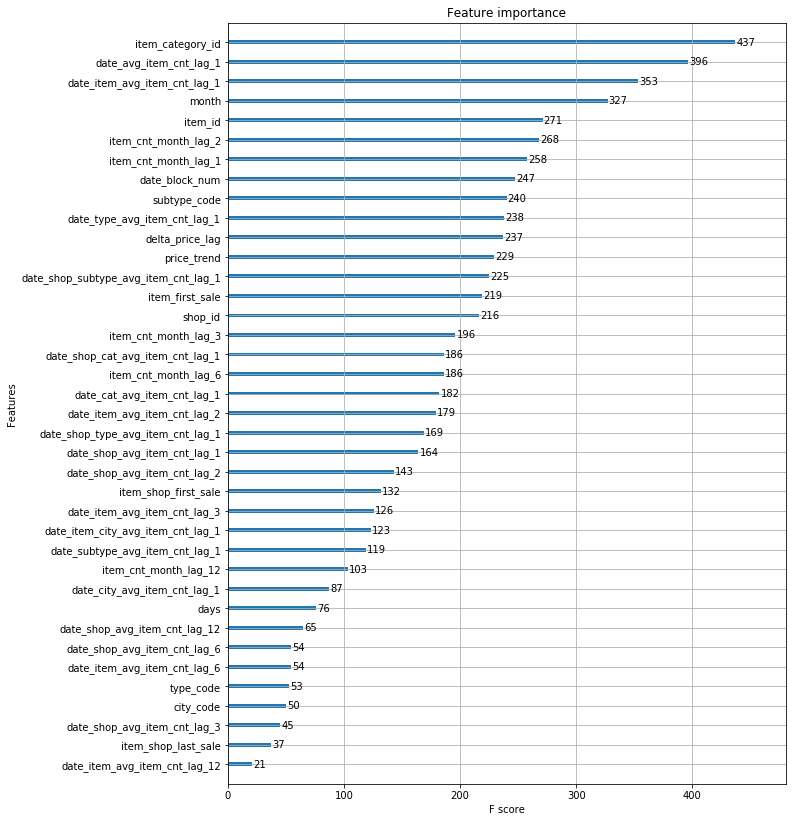

In [120]:
plot_features(model, (10,14))

In [ ]:
# 用LGBM跑一個分數~
